Implement gibbs sampler for bayesian gmm

In [1]:

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import  wishart, dirichlet, invwishart, multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score as ari

# source: https://github.com/is0383kk/GMM-Gibbs/blob/main/gmm_gibbs.ipynb

In [2]:
x_nd_1 = np.loadtxt("../data/data_3_clusters.txt") # Observation1(Corresponds to x_1 in the graphical model)
z_truth_n = np.loadtxt("../data/data_3_clusters_labels.txt") # True label (True z_n)
x_i = x_nd_1

In [3]:
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import numpy as np
from scipy import linalg

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, title):
    plt.figure(figsize=(8, 6))  # Optional: Set the figure size

    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl_patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_alpha(0.5)
        plt.gca().add_patch(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()  # Optional: Display the plot

In [5]:
from importlib import reload

In [6]:
import my_gmm_gibbs
reload(my_gmm_gibbs)
my_gibbs = my_gmm_gibbs.GMMGibbsSampler(x_i, 6, iterations=50, Z_true=z_truth_n)

In [7]:
my_gmm = my_gibbs.fit()

starting gibbs sampling
completed gibbs sampling


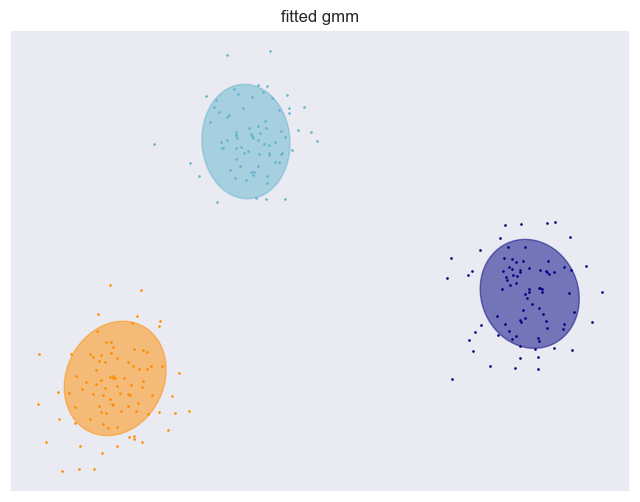

In [8]:
plot_results(x_i, my_gmm.predict(x_i), my_gmm.means_, my_gmm.covariances_, 'fitted gmm')

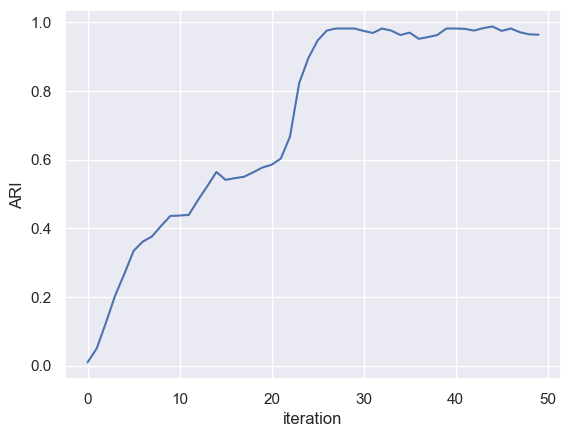

In [9]:
plt.plot(range(0,len(my_gibbs.ARI)), my_gibbs.ARI, marker="None")
plt.xlabel('iteration')
plt.ylabel('ARI')
#plt.savefig("./image/ari.png")
plt.show()
plt.close()

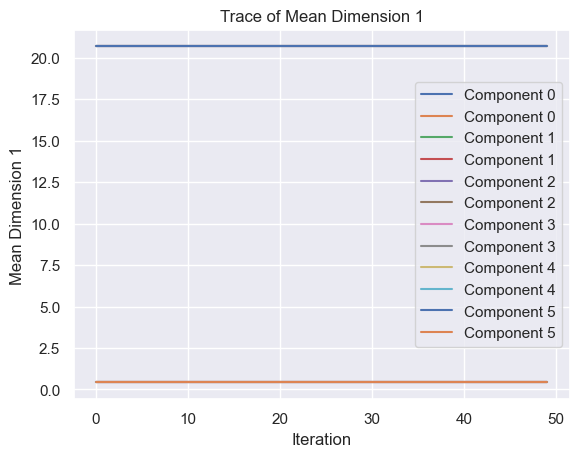

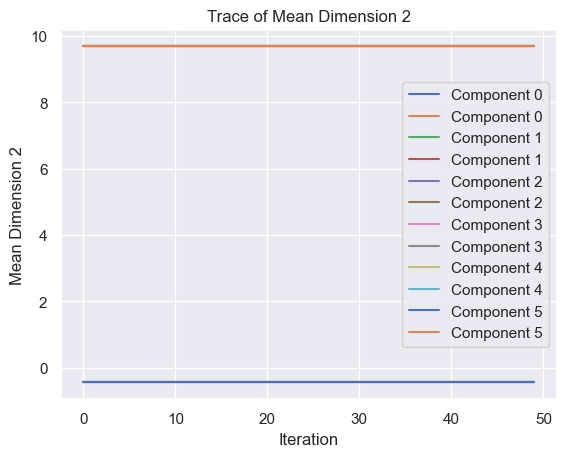

In [10]:
for dim in range(my_gibbs.D):
    plt.figure()
    plt.title(f"Trace of Mean Dimension {dim + 1}")
    for k in range(my_gibbs.K):
        trace_k = [mu[dim] for mu in my_gibbs.mu_trace]  # Extract the trace for dimension 'dim' of component 'k'
        plt.plot(range(len(my_gibbs.mu_trace)), trace_k, label=f"Component {k}")
    plt.xlabel("Iteration")
    plt.ylabel(f"Mean Dimension {dim + 1}")
    plt.legend()
    plt.show()

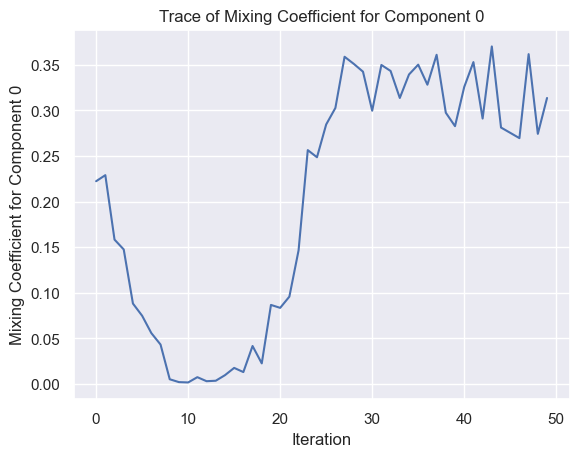

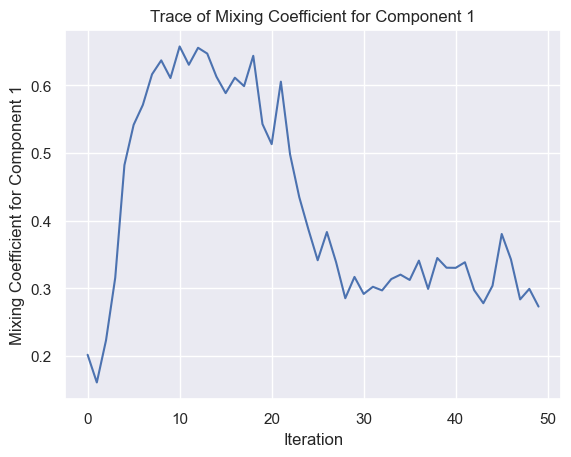

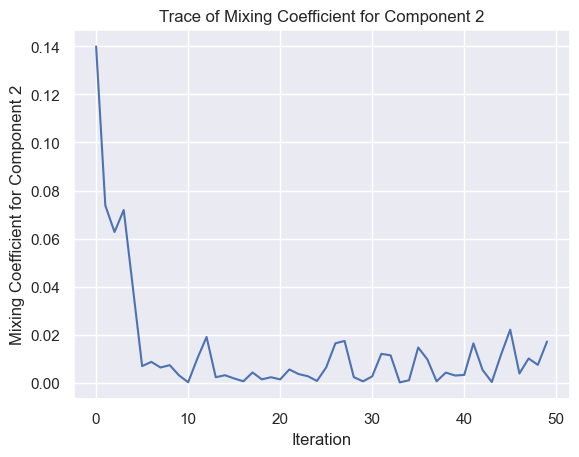

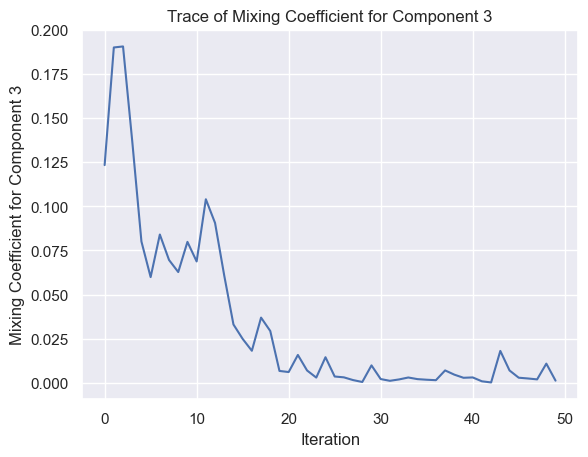

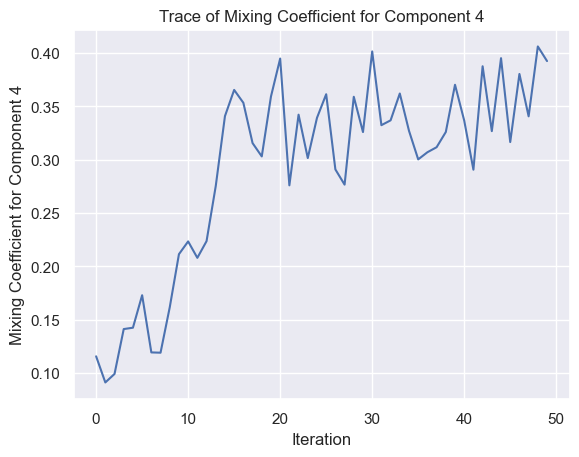

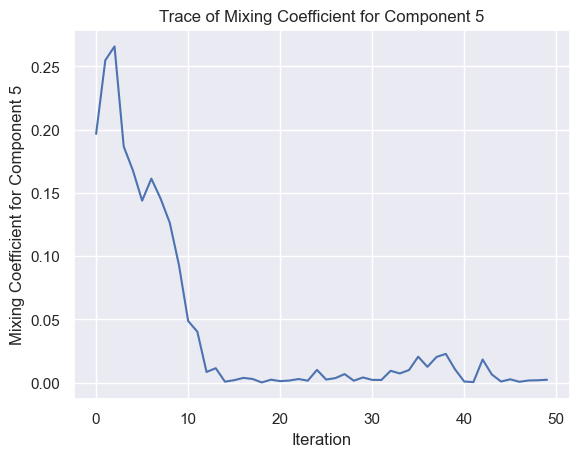

In [11]:
for k in range(my_gibbs.K):
    trace_k = [pi[k] for pi in my_gibbs.pi_trace]  # Extract the trace for component 'k'
    plt.figure()
    plt.title(f"Trace of Mixing Coefficient for Component {k}")
    plt.plot(range(len(my_gibbs.pi_trace)), trace_k)
    plt.xlabel("Iteration")
    plt.ylabel(f"Mixing Coefficient for Component {k}")
    plt.show()